In [58]:
import h5py
import matplotlib.pyplot as plt
from nolitsa import data, lyapunov
import numpy as np
from scipy import spatial
from scipy import stats
from statsmodels.tsa import stattools
import sys
import time 
from tqdm.notebook import tqdm

sys.path.append('..')
from utils import *
from nld_utils import *

In [5]:
data_path = '../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
lfp_areas = [to_string(item, f) for item in f['electrodeInfo']['area'][0]]

In [60]:
airPuff_binary, audio_binary = get_binary_stimuli(f)
get_phase_ranges(f)

{'experiment': array([[   0.   , 7085.395]]),
 'initial_phase': array([[   0.        , 1875.35996667]]),
 'loading_phase': array([[1875.35996667, 3675.35996667]]),
 'maintenance_phase': array([[3675.35996667, 5494.06313333]]),
 'unconscious_phase': array([[2315.67226667, 5618.68623333]]),
 'conscious_phase': array([[   0.        , 2315.67226667],
        [5618.68623333, 7085.395     ]]),
 'post_anesthesia_phase': array([[5494.06313333, 7085.395     ]])}

In [63]:
stimuli = {}
for stim_name, stim in [('AirPuff Binary', airPuff_binary), ('Audio Binary', audio_binary)]:
    stim_begin = (np.diff(stim) == 1).astype(np.int)
    stim_end = (np.diff(stim) == -1).astype(np.int)
    stimuli[stim_name + ' (From Start)'] = stim_begin
    stimuli[stim_name + ' (From End)'] = stim_end

# both and separate
tone_only_begin = np.zeros(len(stim))
tone_only_end = np.zeros(len(stim))
puff_only_begin = np.zeros(len(stim))
puff_only_end = np.zeros(len(stim))
both_begin = np.zeros(len(stim))
both_end = np.zeros(len(stim))
count = 0
for t, (puffOn, toneOn) in enumerate(zip(f['trialInfo']['cpt_puffOn'][:, 0], f['trialInfo']['cpt_toneOn'][:, 0])):
    if np.isnan(puffOn):
        tone_only_begin[int(toneOn*1000)] = 1
        tone_only_end[int(f['trialInfo']['cpt_toneOff'][t, 0]*1000)] = 1
    elif np.isnan(toneOn):
        puff_only_begin[int(puffOn*1000)] = 1
        puff_only_end[int(f['trialInfo']['cpt_puffOff'][t, 0]*1000)] = 1
    else: # both are on
        count += 1
        both_begin[int(np.min([toneOn, puffOn])*1000)] = 1
        both_end[int(np.max([f['trialInfo']['cpt_toneOff'][t, 0], f['trialInfo']['cpt_puffOff'][t, 0]])*1000)] = 1
stimuli['Tone Only (From Start)'] = tone_only_begin
stimuli['Tone Only (From End)'] = tone_only_end
stimuli['Puff Only (From Start)'] = puff_only_begin
stimuli['Puff Only (From End)'] = puff_only_end
stimuli['Tone and Puff (From Start)'] = both_begin
stimuli['Tone and Puff (From End)'] = both_end

In [8]:
unit_index = 0

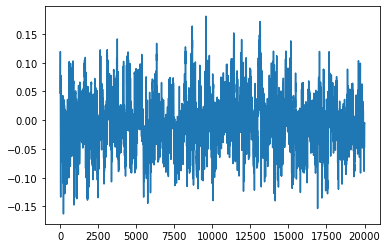

In [59]:
signal_start = 1500 # s
duration = 20 # s
length = int(duration/dt)
start_step = int(signal_start/dt)
signal = f['lfp'][unit_index, start_step:start_step + length]
plt.plot(signal)
# print(plt.xticks()[0])
plt.show()

In [66]:
print(f"there are {int(np.sum(stimuli['Tone Only (From Start)'][start_step:start_step + length]))} tone(s) in this region and {int(np.sum(stimuli['Puff Only (From Start)'][start_step:start_step + length]))} puff(s)") 

there are 1 tone(s) in this region and 2 puff(s)


In [67]:
# tau

# tau = np.argmax(np.abs(stattools.pacf(signal, nlags=500, method='ldb')) < 2/np.sqrt(len(signal)))
tau = np.argmax(stattools.acf(signal, nlags=500, adjusted='True', fft=False) < 0)
tau

162

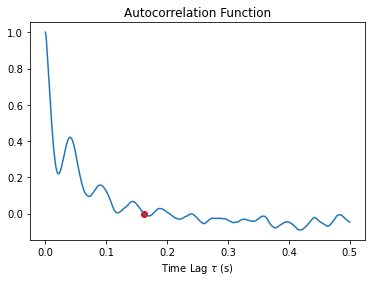

In [68]:
# plt.plot(stattools.pacf(signal, nlags=500, method='ldb'))
plt.plot(stattools.acf(signal, nlags=500, adjusted='True', fft=False))
plt.title('Autocorrelation Function')
plt.xlabel(r'Time Lag $\tau$ (s)')
xticks = plt.xticks()[0][1:-1]
plt.xticks(xticks, xticks*dt)
plt.scatter(tau, 0, c='red')
plt.show()

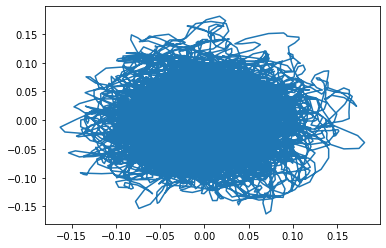

In [69]:
plt.plot(signal[:len(signal) - tau], signal[tau:])

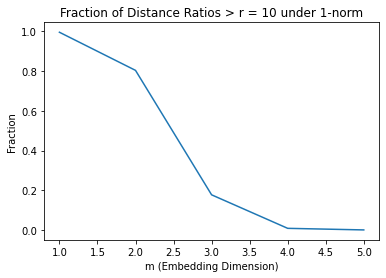

In [74]:
p = 1
r = 10

M_vals = np.arange(1, 6)
fraction_fnn = np.zeros(M_vals.shape)

for i, m in enumerate(M_vals):
    embedding = embed_signal(signal, m, tau=tau)
    nn_indices, _ = get_nn_indices(embedding, p=p)
    fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
    fraction_fnn[i] = fraction_greater
    
plt.plot(M_vals, fraction_fnn)
plt.xlabel('m (Embedding Dimension)')
plt.title(f'Fraction of Distance Ratios > r = {r} under {p}-norm')
plt.ylabel('Fraction')
plt.show()

m = 4


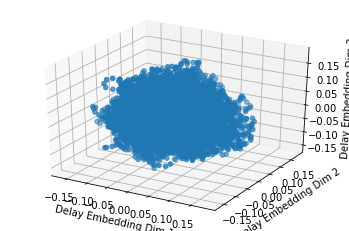

In [77]:
m = np.argmax(fraction_fnn < 0.1) + 1
print(f"m = {m}")
embedding = embed_signal(signal, m, tau=tau)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_xlabel('Delay Embedding Dim 1')
ax.set_ylabel('Delay Embedding Dim 2')
ax.set_zlabel('Delay Embedding Dim 3')
plt.show()

In [78]:
# Choose appropriate Theiler window.
window = 60
maxt = 1000
d = nolitsa.lyapunov.mle_embed(signal, dim=[m], tau=tau, maxt=maxt, window=window)[0]
t = np.arange(maxt)

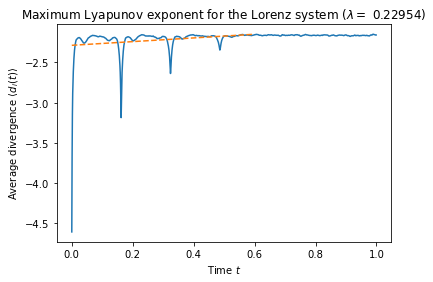

In [79]:
end_linear = 600
slope, intercept, _, _, _ = stats.linregress(dt*t[:end_linear], d[:end_linear])
plt.title(fr'Maximum Lyapunov exponent for the Lorenz system ($\lambda =$ {slope:.5f})')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(dt * t, d)
plt.plot(dt*t[:end_linear], slope*dt*t[:end_linear] + intercept, linestyle='--')
# plt.plot(dt * t, sample * t * 1, '--')

plt.show()

- recompute $\tau$ and $m$
- expect $\lambda$ to be smaller than in the anaesthetic case (more stable)
- ignore stimuli